In [ ]:
#Code sourced from following links
#https://github.com/sarthak25/Brain-tumor-segmentation
#https://github.com/karolzak/keras-unet/tree/master/keras_unet
#https://github.com/MohamedAliHabib/Brain-Tumor-Detection
#https://github.com/charan223/Brain-Tumor-Segmentation-using-Topological-Loss
#https://github.com/sdsubhajitdas/Brain-Tumor-Segmentation
#https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation
#https://github.com/yunyuntsai/BraTS-brain-tumer-segmentation/blob/master/Seg_net.ipynb

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Conv3D, MaxPooling3D, Conv3DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
#import tensorflow as tf

import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob

import numpy as np
import random as r
import cv2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.__version__

'2.8.0'

In [ ]:
!pip install simpleitk

In [ ]:
path = "/content/drive/My Drive/Dataset/HGG/Subset/"

In [ ]:
files = glob(path+"**/*flair.nii.gz")

len(files)

259

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.5.217.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.217.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Device: grpc://10.5.217.26:8470
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


# Convert to Array

In [ ]:
first_img = io.imread(files[1], plugin="simpleitk")

print(f"shape: {first_img.shape}")
print(f"dtype: {first_img.dtype}")

shape: (155, 240, 240)
dtype: int16


## Visualize Flair Image

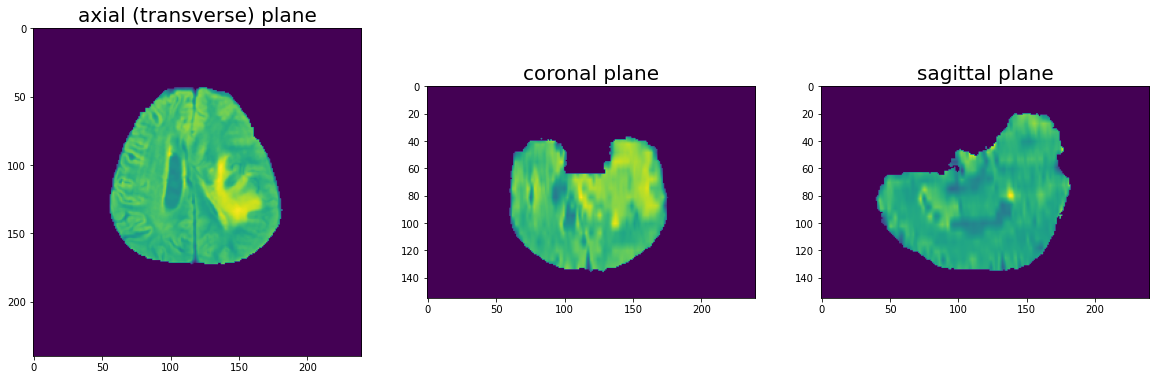

In [ ]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(first_img[100,:,:])
plt.title("axial (transverse) plane", fontsize=20)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(first_img[:,100,:])
plt.title("coronal plane", fontsize=20)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(first_img[:,:,100])
plt.title("sagittal plane", fontsize=20);

## Visualize Segmented Image

In [ ]:
files[1]

'/content/drive/My Drive/Dataset/HGG/Subset/BraTS19_TMC_06290_1/BraTS19_TMC_06290_1_flair.nii.gz'

In [ ]:
seg_img = io.imread('/content/drive/MyDrive/Dataset/HGG/Subset/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii.gz', plugin="simpleitk")

print(f"shape: {seg_img.shape}")
print(f"dtype: {seg_img.dtype}")

shape: (155, 240, 240)
dtype: int16


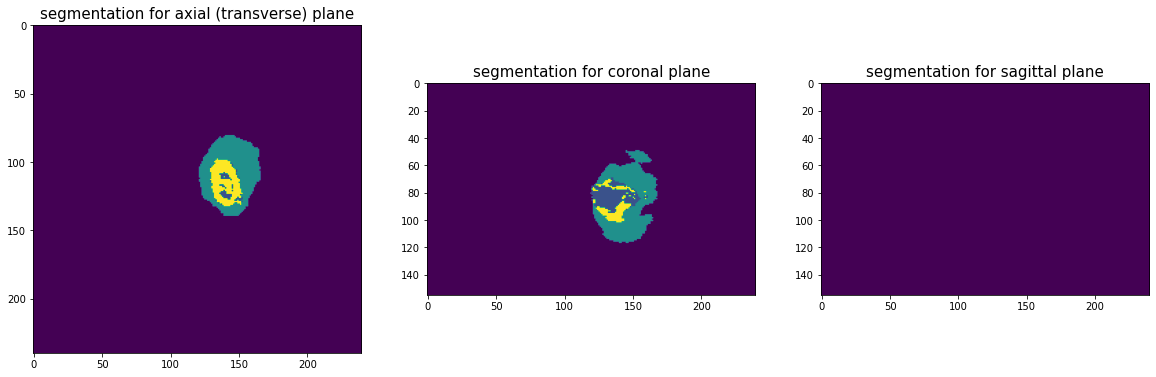

In [ ]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(seg_img[100,:,:])
plt.title("segmentation for axial (transverse) plane", fontsize=15)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(seg_img[:,100,:])
plt.title("segmentation for coronal plane", fontsize=15)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(seg_img[:,:,100])
plt.title("segmentation for sagittal plane", fontsize=15);

# Convert to Array 

In [ ]:
def to_array(path, end):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    single_img = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")

        # standardization
        img = (img-img.mean())/img.std()
        img.astype("float32")
        
        for slice in range(60, 124):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (128,128))
            single_img.append(img_s)
        img_list.append(single_img)
        single_img = []

            
    return np.array(img_list,np.float32)

### np.expand_dims()

In [ ]:
first_img.shape

(155, 240, 240)

In [ ]:
exp = first_img[60,:,:]

exp.shape

(240, 240)

In [ ]:
exp = np.expand_dims(exp, axis=0)

exp.shape

(1, 240, 240)

# Applying the Function

In [ ]:
train = to_array(path=path, end="**/*flair.nii.gz")

In [ ]:
train.shape

(18130, 1, 128, 128)

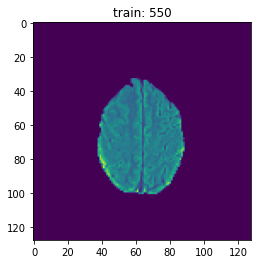

In [ ]:
plt.imshow(train[550].reshape(128,128))
plt.title("train: 550");

In [ ]:
t1ce = to_array(path=path, end='**/*t1ce.nii.gz')

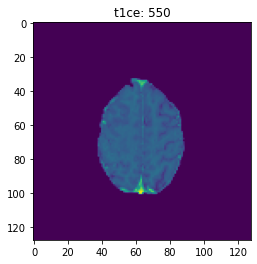

In [ ]:
plt.imshow(t1ce[550].reshape(128,128))
plt.title("t1ce: 550");

# Segmented Images

1 - Non-enhancing Tumor

2 - Edema 

4 - Enhancing Tumor

In [ ]:
seg_img.shape

(155, 240, 240)

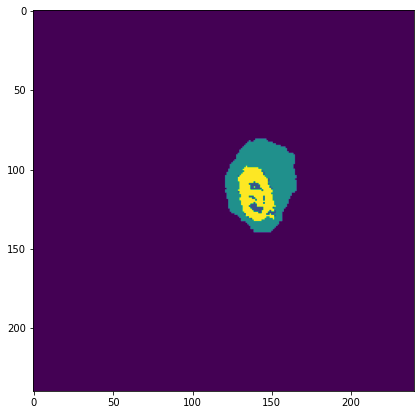

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(seg_img[100,:,:]);

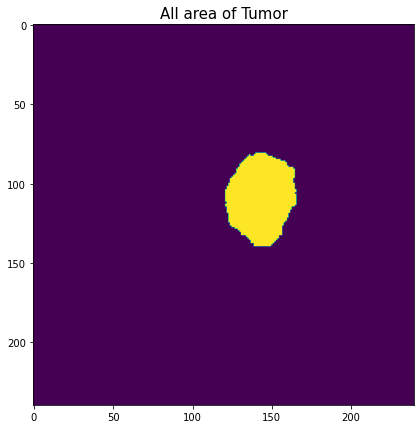

In [ ]:
seg_all = seg_img.copy()

seg_all[seg_all != 0] = 1 # show all tumor area

plt.figure(figsize=(7,7))
plt.imshow(seg_all[100,:,:])
plt.title("All area of Tumor", fontsize=15);

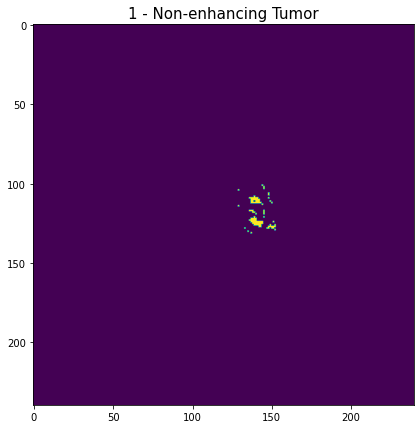

In [ ]:
seg_non = seg_img.copy()

seg_non[seg_non != 1] = 0 # show non-enhancing tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_non[100,:,:])
plt.title("1 - Non-enhancing Tumor", fontsize=15);

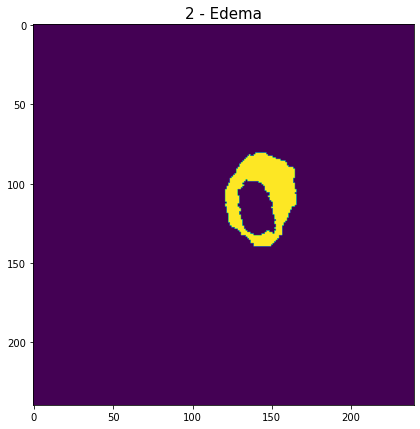

In [ ]:
seg_edema = seg_img.copy()

seg_edema[seg_edema == 1] = 0 # cover Non-enhancing Tumor
seg_edema[seg_edema == 4] = 0 # cover Enhancing Tumor
seg_edema[seg_edema != 0] = 1 # show Edema

plt.figure(figsize=(7,7))
plt.imshow(seg_edema[100,:,:])
plt.title("2 - Edema", fontsize=15);

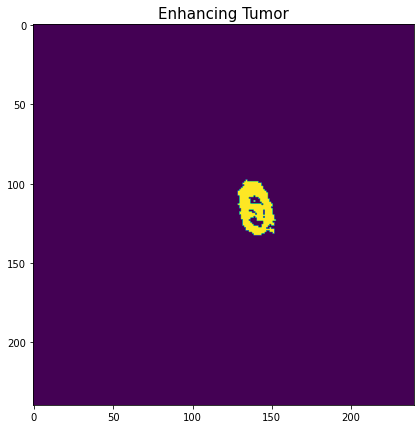

In [ ]:
seg_enhancing = seg_img.copy()

seg_enhancing[seg_enhancing != 4] = 0 # show Enhancing Tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_enhancing[100,:,:])
plt.title("Enhancing Tumor", fontsize=15);

# To Array for Segmented Images

In [ ]:
def image_to_array(path, end, label):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    single_img = []
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        
        # all tumor
        if label == 1:
            img[img != 0] = 1
        
        # Non-enhancing Tumor
        if label == 2:
            img[img != 1] = 0
        
        # Without Edema
        if label == 3:
            img[img == 2] = 0
            img[img != 0] = 1
        
        # Enhancing Tumor
        if label == 4:
            img[img != 4] = 0
            img[img == 4] = 1
            

        img.astype("float32")
        
        for slice in range(60, 124):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (128,128))
            single_img.append(img_s)
      #      img_s1 = np.expand_dims(img_s1, axis=0)
        img_list.append(single_img)
        single_img = []
          #  img_list.concatenate(img_s, axis=0)
            
    return np.array(img_list,np.float32)

In [ ]:
seg_all_tumor = image_to_array(path=path, end="**/*seg.nii.gz", label=1)

#seg_non_enhancing = image_to_array(path=path, end="**/*seg.nii.gz", label=2)

#seg_out_edema = image_to_array(path=path, end="**/*seg.nii.gz", label=3) 

#seg_enhancing = image_to_array(path=path, end="**/*seg.nii.gz", label=4) 

#seg_original = image_to_array(path=path, end="**/*seg.nii.gz", label=0)

In [ ]:
seg_all_tumor.shape

(259, 64, 128, 128)

In [ ]:
seg_non_enhancing.shape

(18130, 1, 128, 128)

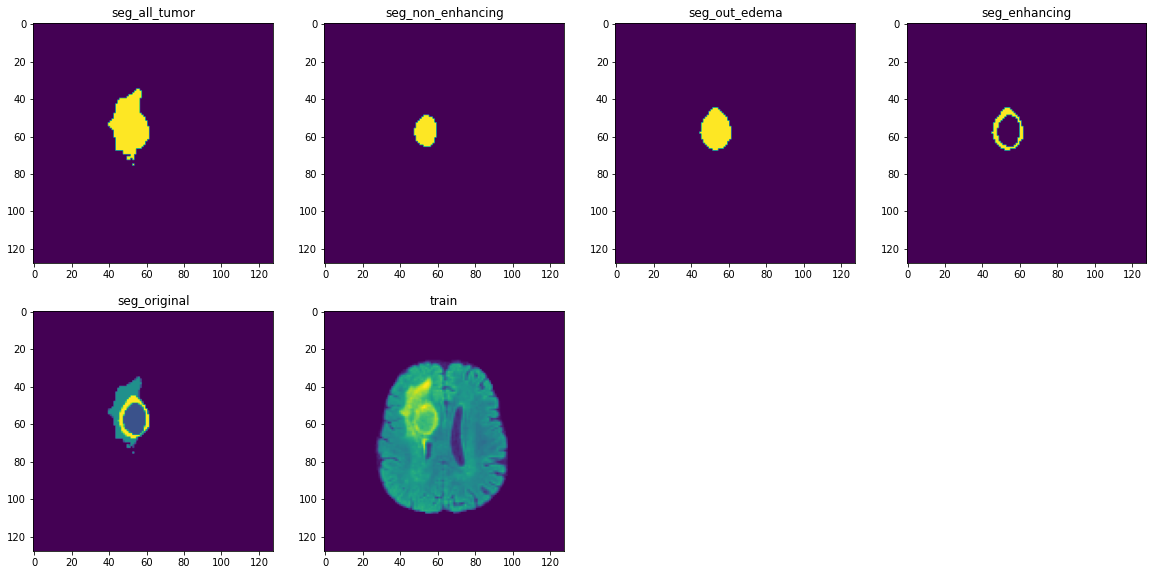

In [ ]:
idx = 100

plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(seg_all_tumor[idx].reshape(128,128))
plt.title("seg_all_tumor")

plt.subplot(3,4,2)
plt.imshow(seg_non_enhancing[idx].reshape(128,128))
plt.title("seg_non_enhancing")

plt.subplot(3,4,3)
plt.imshow(seg_out_edema[idx].reshape(128,128))
plt.title("seg_out_edema")

plt.subplot(3,4,4)
plt.imshow(seg_enhancing[idx].reshape(128,128))
plt.title("seg_enhancing")

plt.subplot(3,4,5)
plt.imshow(seg_original[idx].reshape(128,128))
plt.title("seg_original")

plt.subplot(3,4,6)
plt.imshow(train[idx].reshape(128,128))
plt.title("train");

# U-NET MODEL

In [ ]:
flair = to_array(path=path, end="**/*flair.nii.gz")
#t2 = to_array(path=path, end="**/*t2.nii.gz")
#seg = image_to_array(path=path, end="**/*seg.nii.gz", label=1)

In [ ]:
flair.shape#, t2.shape #seg.shape

## Concatenate

In [ ]:
X_train = np.concatenate((flair, t2), axis=1)

In [ ]:
X_train = flair
X_train = np.expand_dims(X_train, axis=4)

In [ ]:
X_train.shape

(259, 64, 128, 128, 1)

In [ ]:
X_train.dtype

dtype('float32')

# U-NET MODEL

In [ ]:
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import MeanIoU

def iou(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (union + smooth)

def tversky(y_true, y_pred):
    smooth = 0.005
    #Define alpha and beta
    alpha = 0.3
    beta = 0.7
    tp = K.sum(y_true * y_pred)
    fn = K.sum(y_true * (1-y_pred))
    fp = K.sum((1-y_true) * y_pred)
    return (tp + smooth)/(tp + alpha*fn + beta*fp + smooth)
    

In [ ]:
from tensorflow.keras import layers

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

K.set_image_data_format('channels_last')


def unet():
    
    inputs = Input((64, 128 , 128, 1))
    
    conv1 = Conv3D(64, kernel_size=3, activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization()(conv1)
    conv1 = Conv3D(64, kernel_size=3, activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=2)(batch1)
    
    conv2 = Conv3D(128, kernel_size=3, activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization()(conv2)
    conv2 = Conv3D(128, kernel_size=3, activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=2)(batch2)
    
    conv3 = Conv3D(256, kernel_size=3, activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization()(conv3)
    conv3 = Conv3D(256, kernel_size=3, activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=2)(batch3)
    
    conv4 = Conv3D(512, kernel_size=3, activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization()(conv4)
    conv4 = Conv3D(512, kernel_size=3, activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization()(conv4)
    pool4 = MaxPooling3D(pool_size=2)(batch4)
    
    conv5 = Conv3D(1024, kernel_size=3, activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization()(conv5)
    conv5 = Conv3D(1024, kernel_size=3, activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization()(conv5)
    
    up6 = Conv3DTranspose(512, (2, 2, 2), strides=(2, 2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=4)
    conv6 = Conv3D(512, (3, 3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization()(conv6)
    conv6 = Conv3D(512, (3, 3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization()(conv6)
    
    up7 = Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=4)
    conv7 = Conv3D(256, kernel_size=3, activation='relu', padding='same') (up7)
    batch7 = BatchNormalization()(conv7)
    conv7 = Conv3D(256, kernel_size=3, activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization()(conv7)
    
    up8 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=4)
    conv8 = Conv3D(128, kernel_size=3, activation='relu', padding='same') (up8)
    batch8 = BatchNormalization()(conv8)
    conv8 = Conv3D(128, kernel_size=3, activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization()(conv8)
    
    up9 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=4)
    conv9 = Conv3D(64, kernel_size=3, activation='relu', padding='same') (up9)
    batch9 = BatchNormalization()(conv9)
    conv9 = Conv3D(64, kernel_size=3, activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization()(conv9)

    conv10 = Conv3D(1, kernel_size=1, activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef, iou, tversky, 'Precision', 'Recall'])

    return model

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 128, 12  0           []                               
                                8, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 64, 128, 128  1792        ['input_1[0][0]']                
                                , 64)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 128, 128  256        ['conv3d[0][0]']                 
 alization)                     , 64)                                                         

In [ ]:
model.fit(X_train, seg_all_tumor, validation_split=0.25, batch_size=1, epochs=1000, shuffle=True)

Epoch 1/1000
194/194 [==============================] - 299s 1s/step - loss: 0.8174 - dice_coef: 0.1826 - iou: 0.1053 - tversky: 0.1412 - precision: 0.1206 - recall: 0.9819 - val_loss: 0.9187 - val_dice_coef: 0.0813 - val_iou: 0.0432 - val_tversky: 0.0601 - val_precision: 0.0435 - val_recall: 1.0000
Epoch 2/1000
194/194 [==============================] - 289s 1s/step - loss: 0.7106 - dice_coef: 0.2894 - iou: 0.1810 - tversky: 0.2334 - precision: 0.2553 - recall: 0.9876 - val_loss: 0.8585 - val_dice_coef: 0.1415 - val_iou: 0.0794 - val_tversky: 0.1077 - val_precision: 0.0753 - val_recall: 1.0000
Epoch 3/1000
194/194 [==============================] - 289s 1s/step - loss: 0.6339 - dice_coef: 0.3661 - iou: 0.2428 - tversky: 0.3049 - precision: 0.3513 - recall: 0.9718 - val_loss: 0.8476 - val_dice_coef: 0.1524 - val_iou: 0.0866 - val_tversky: 0.1167 - val_precision: 0.0799 - val_recall: 1.0000
Epoch 4/1000
194/194 [==============================] - 289s 1s/step - loss: 0.5706 - dice_coef: 

KeyboardInterrupt: ignored

In [ ]:
model.save_weights("/content/drive/MyDrive/Dataset/subset_model.h5")

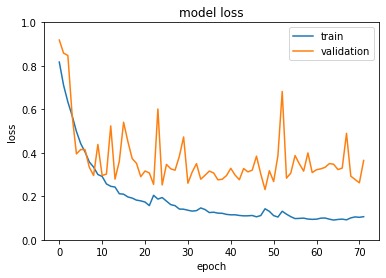

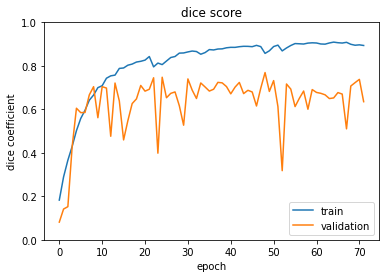

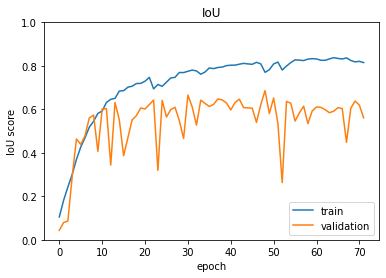

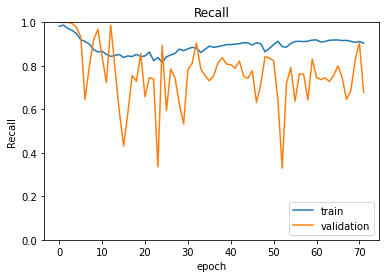

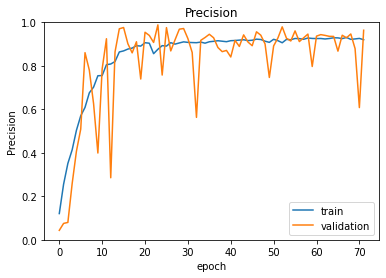

In [ ]:
plt.plot(model.history.history['loss'])

plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')
plt.show()





plt.plot(model.history.history['dice_coef'])
plt.plot(model.history.history['val_dice_coef'])
plt.title('dice score')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('dice coefficient')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(model.history.history['iou'])
plt.plot(model.history.history['val_iou'])
plt.ylim(0, 1)
plt.title('IoU')
plt.xlabel('epoch')
plt.ylabel('IoU score')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(model.history.history['recall'])
plt.plot(model.history.history['val_recall'])
plt.ylim(0, 1)
plt.title('Recall')
plt.xlabel('epoch')
plt.ylabel('Recall')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(model.history.history['precision'])
plt.plot(model.history.history['val_precision'])
plt.ylim(0, 1)
plt.title('Precision')
plt.xlabel('epoch')
plt.ylabel('Precision')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

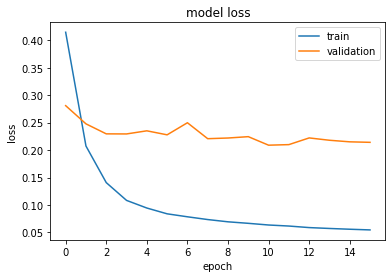

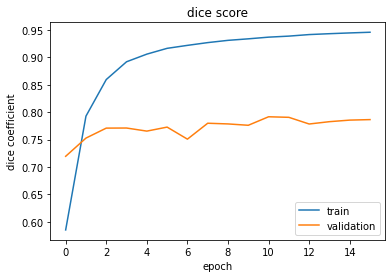

In [ ]:

plt.plot(model.history.history['loss'])

plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')
plt.show()





plt.plot(model.history.history['dice_coef'])
plt.plot(model.history.history['val_dice_coef'])
plt.title('dice score')
plt.xlabel('epoch')
plt.ylabel('dice coefficient')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# PREDICTION

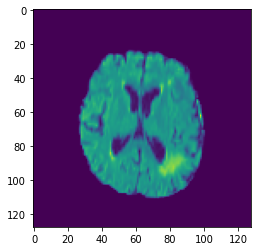

In [ ]:
plt.imshow(X_train[1000][0]);

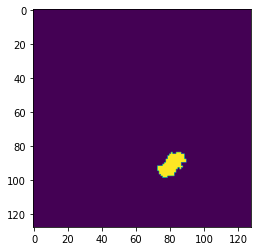

In [ ]:
plt.imshow(seg[1000][0]);

In [ ]:
expand_img = np.expand_dims(X_train[1000], axis=0)

pred = model.predict(expand_img)

## Visualize Prediction

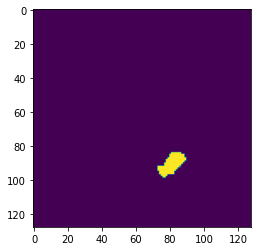

In [ ]:
plt.imshow(pred[0][0]);

tf.Tensor(0.181982, shape=(), dtype=float32)


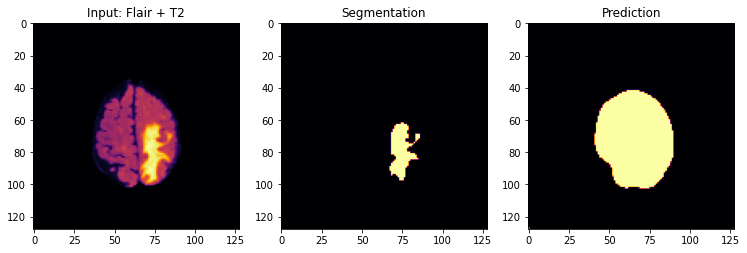

In [ ]:
x = 333

sample = np.expand_dims(X_train[x], axis=0)
pred = model.predict(sample)


fig = plt.figure(figsize=(17, 15))

plt.subplot(1,4,1)
plt.title("Input: Flair + T2")
plt.imshow(X_train[x][0], cmap="inferno")

plt.subplot(1,4,2)
plt.title("Segmentation")
plt.imshow(seg[x][0], cmap="inferno")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred[0][0], cmap="inferno");

results = 0
for i in range(2000):
  sample = np.expand_dims(X_train[i], axis=0)
  pred = model.predict(sample)
  results += dice_coef(seg[i][0],pred[0][0])

print(results/2000)

# Cropping Images

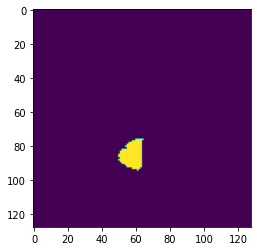

In [ ]:
tmp = seg_out_edema[666,0,:,:]

tmp.shape

plt.imshow(tmp);

In [ ]:
# threshold
tmp[tmp > 0.2] = 1
tmp[tmp != 1] = 0

In [ ]:
index_xy = np.where(tmp==1)

In [ ]:
index_xy[0]

array([76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78,
       78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82,
       82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83,
       83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
       85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86,
       86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87,
       87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91,
       91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93,
       93, 93, 94])

In [ ]:
index_xy[1]

array([60, 61, 62, 63, 64, 58, 59, 60, 61, 62, 63, 56, 57, 58, 59, 60, 61,
       62, 63, 55, 56, 57, 58, 59, 60, 61, 62, 63, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 55, 56, 57, 58, 59, 60, 61, 62, 63, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 55, 56, 57, 58, 59, 60, 61, 62, 63, 58, 59, 60,
       61, 62, 61])

In [ ]:
center_y = (max(index_xy[0]) + min(index_xy[0])) / 2

center_y

85.0

In [ ]:
center_x = (max(index_xy[1]) + min(index_xy[1])) / 2

center_x

57.0

In [ ]:
img_x = np.zeros((64,64), np.float32)

img_x.shape

(64, 64)

In [ ]:
x = t1ce[666,0,:,:]
x.shape

(128, 128)

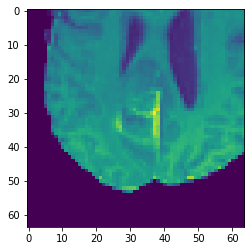

In [ ]:
img_x[:,:] = x[int(center_y - 64/2): int(center_y + 64/2), int(center_x - 64/2): int(center_x + 64/2)]


plt.imshow(img_x);

In [ ]:
seg_ = seg_out_edema[666,0,:,:]

seg_.shape

(128, 128)

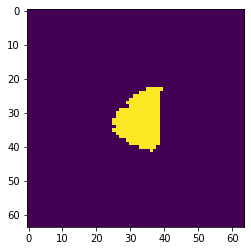

In [ ]:
img_x[:,:] = seg_[int(center_y - 64/2): int(center_y + 64/2), int(center_x - 64/2): int(center_x + 64/2)]


plt.imshow(img_x);

In [ ]:
def crop_tumor(mr, seg):
  
  mr = mr[0]
  list_ = []

  # thresholding
  tmp = seg[0,:,:]
  tmp[tmp > 0.2] = 1
  tmp[tmp != 1] = 0
  index_xy = np.where(tmp==1)

  # some images contain no tumor !
  if index_xy[0] != []:

    center_y = (max(index_xy[0]) + min(index_xy[0])) / 2
    center_x = (max(index_xy[1]) + min(index_xy[1])) / 2

    img_x = np.zeros((64,64), np.float32)

    img_x[:,:] = mr[int(center_y - 64/2):int(center_y + 64/2), int(center_x - 64/2):int(center_x + 64/2)]

    list_.append(img_x)
  
  return np.array(list_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


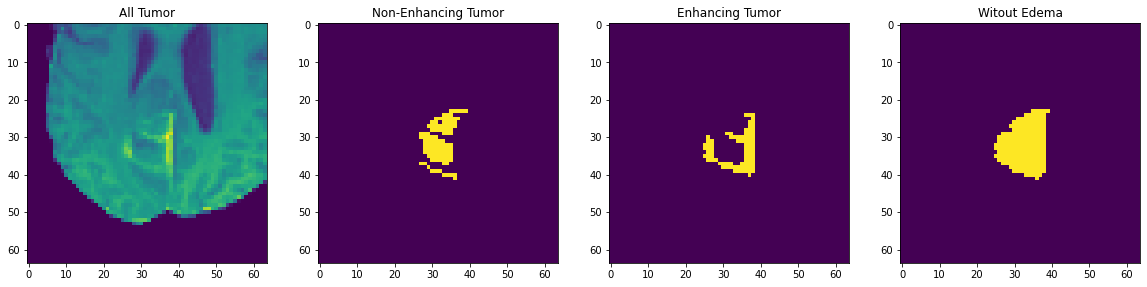

In [ ]:
img_666 = crop_tumor(mr=t1ce[666], seg=seg_out_edema[666])
non_666 = crop_tumor(mr=seg_non_enhancing[666], seg=seg_out_edema[666])
enhancing_666 = crop_tumor(mr=seg_enhancing[666], seg=seg_out_edema[666])
without_edema_666 = crop_tumor(mr=seg_out_edema[666], seg=seg_out_edema[666])


plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(img_666[0])
plt.title("All Tumor")

plt.subplot(3,4,2)
plt.imshow(non_666[0])
plt.title("Non-Enhancing Tumor")

plt.subplot(3,4,3)
plt.imshow(enhancing_666[0])
plt.title("Enhancing Tumor")

plt.subplot(3,4,4)
plt.imshow(without_edema_666[0])
plt.title("Witout Edema");